In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils.plotting import plot_series

# = = = = = =
# own stuff

os.chdir("C:/Users/ytl_c/OneDrive/Desktop/23_24 WS (Master)/VL - PTSFC/2023_11-PTSFC")
from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [20]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


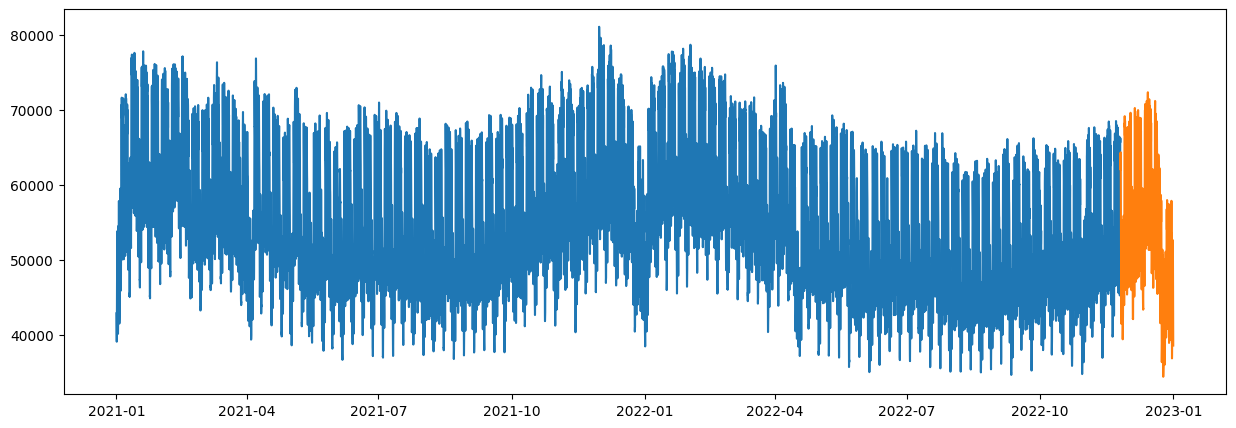

In [39]:
# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
# take smaller dataset
start   = '2021-01-01'
end     = '2023-01-01'
df_energy_small = df_energy.loc[(df_energy['timestamp_CET'] > start) & 
                                (df_energy['timestamp_CET'] <= end)]

n_total = df_energy_small.shape[0]
n_train = int(n_total * 0.95)

y_train = df_energy_small.iloc[:n_train]['gesamt']
y_test = df_energy_small.iloc[n_train:]['gesamt']

plt.figure(figsize=(15, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.show()

c:\Users\ytl_c\miniconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\ytl_c\miniconda3\Lib\site-packages\sktime\forecasting\base\_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)
c:\Users\ytl_c\miniconda3\Lib\site-packages\sktime\forecasting\base\_fh.py:862: UserWarning: Converting to Period representation will drop timezone information.
  return x.to_period(freq)
c:\Users\ytl_c\miniconda3\Lib\site-packages\sktime\forecasting\base\_fh.py:862: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.to_period(freq)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='gesamt'>)

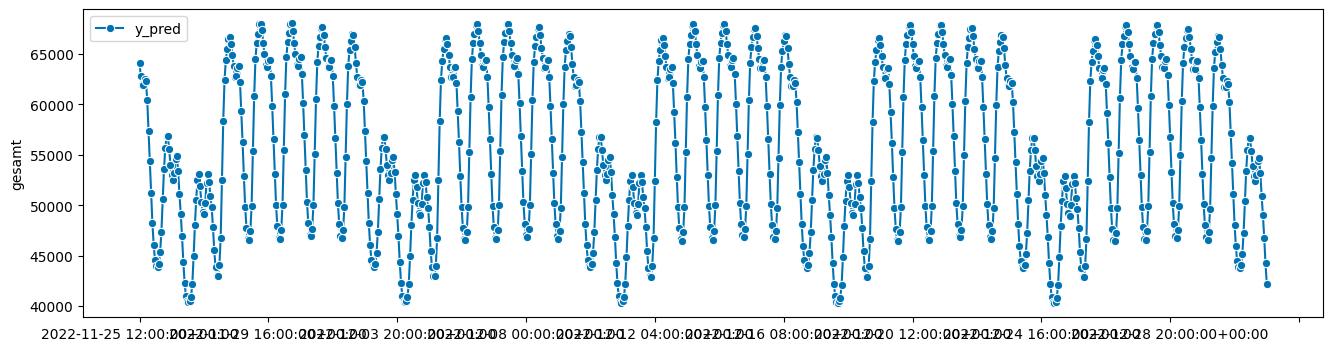

In [46]:
# y = load_airline()

forecaster = ThetaForecaster(sp=7*24) 
forecaster.fit(y_train)

fh = y_test.index
y_pred = forecaster.predict(fh)
plot_series(y_pred, labels=["y_pred"])

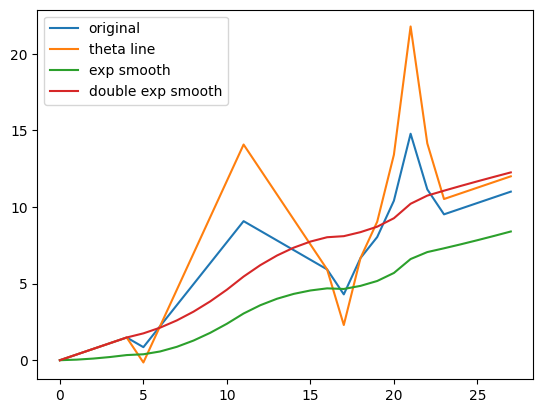

In [200]:
# = = = = = = = = = = = = = = = = = =
# input data to be fed into the model

# - - - - - - - 
# simple curve
y = np.array([0, 0, 0, 0, 0, -1, 0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0, -2, 0, 1, 3, 7, 3, 1, 1, 1, 1, 1])
trend = np.linspace(0, 10, len(y))
y = y + trend
# - - - - - - - 
# straight line
# y = np.array([0,0,1,2,3,4,5,6,7,8,7,10,20,-10,-50,70])
# - - - - - - - 
# gaussian noise
# y = np.append(np.zeros(2), np.random.normal(0, 1, 100))

# = = = = = = = = = = = = = = = = = =
# theta model
# X''_new(theta) = theta * X''_data
# X''_data = X_t - 2*X_t-1 + X_t-2

""" 
for this implmentation of the theta model to work 
we need to add 2 zeros in front of the series
because in the reconstruction based on the theta weighted second differences
the first values of the first difference and the original series are taken as given
if these are not 0, the reconstruction will blow up for theta = 0
"""

theta = 2
second_diff = y[2:] - 2*y[1:-1] + y[:-2]

# reconstruct first_diff from theta * second_diff
# take first value of first diff as from actual series as given and add theta * second_diff recursively
first_diff = np.zeros(len(y)-1)
first_diff[0] = y[1] - y[0]
for i in range(0, len(y)-2):
    first_diff[i+1] = theta * second_diff[i] + first_diff[i]

# given first diff, reconstruct y
# again, taking first value of y from actual series as given and add first diff recursively
theta_line = np.zeros(len(y))
theta_line[0] = y[0]
for i in range(0, len(y)-1):
    theta_line[i+1] = theta_line[i] + first_diff[i]

# = = = = = = = = = = = = =
# Exponential Smoothing
# s_0 = x_0
# s_t = alpha * x_t + (1-alpha) * s_t-1

""" 
The name 'exponential smoothing' is attributed to the use of the exponential window function during convolution

The term smoothing factor applied to \alpha  here is something of a misnomer, 
as larger values of \alpha  actually reduce the level of smoothing, 
and in the limiting case with \alpha  = 1 the output series is just the current observation. 
Values of \alpha close to one have less of a smoothing effect and give greater weight to recent changes in the data, 
while values of \alpha closer to zero have a greater smoothing effect and are less responsive to recent changes.

Technically it can also be classified as an ARIMA(0,1,1) model with no constant term

Exponential smoothing and moving average have similar defects of introducing a lag relative to the input data.
While this can be corrected by shifting the result by half the window length for a symmetrical kernel, 
such as a moving average or gaussian, it is unclear how appropriate this would be for exponential smoothing

In the signal processing literature, the use of non-causal (symmetric) filters is commonplace, 
and the exponential window function is broadly used in this fashion
=> !!! CHECK again what non-causal means
"""

alpha   = 0.1
s       = np.zeros(len(y))
s[0]    = y[0]

for i in range(1, len(y)):
    s[i] = alpha * y[i] + (1-alpha) * s[i-1]

# = = = = = = = = = = = = =
# Double Exponential Smoothing
# s_0 = x_0
# b_0 = x_1 - x_0
# s_t = alpha * x_t + (1-alpha) * (s_t-1 + b_t-1)
# b_t = beta * (s_t - s_t-1) + (1-beta) * b_t-1

alpha   = 0.1
beta    = 0.1

s_2     = np.zeros(len(y))
b       = np.zeros(len(y))
s[0]    = y[0]
b[0]    = y[1] - y[0]

for i in range(1, len(y)):
    s_2[i] = alpha * y[i] + (1-alpha) * (s_2[i-1] + b[i-1])
    b[i] = beta * (s_2[i] - s_2[i-1]) + (1-beta) * b[i-1]

# = = = = = = = = = = = = =
# Plot
    
plt.plot(y, label='original')
plt.plot(theta_line, label='theta line')
plt.plot(s, label='exp smooth')
plt.plot(s_2, label='double exp smooth')

plt.legend()
plt.show()